In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pickle import load
from sklearn.metrics import mean_squared_error

########## Test dataset #########

In [15]:
# Load scaler/ index
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))
train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)


In [16]:
# Load test dataset/ model
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)

/tmp/ipykernel_15769/3651076424.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
/tmp/ipykernel_15769/3651076424.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


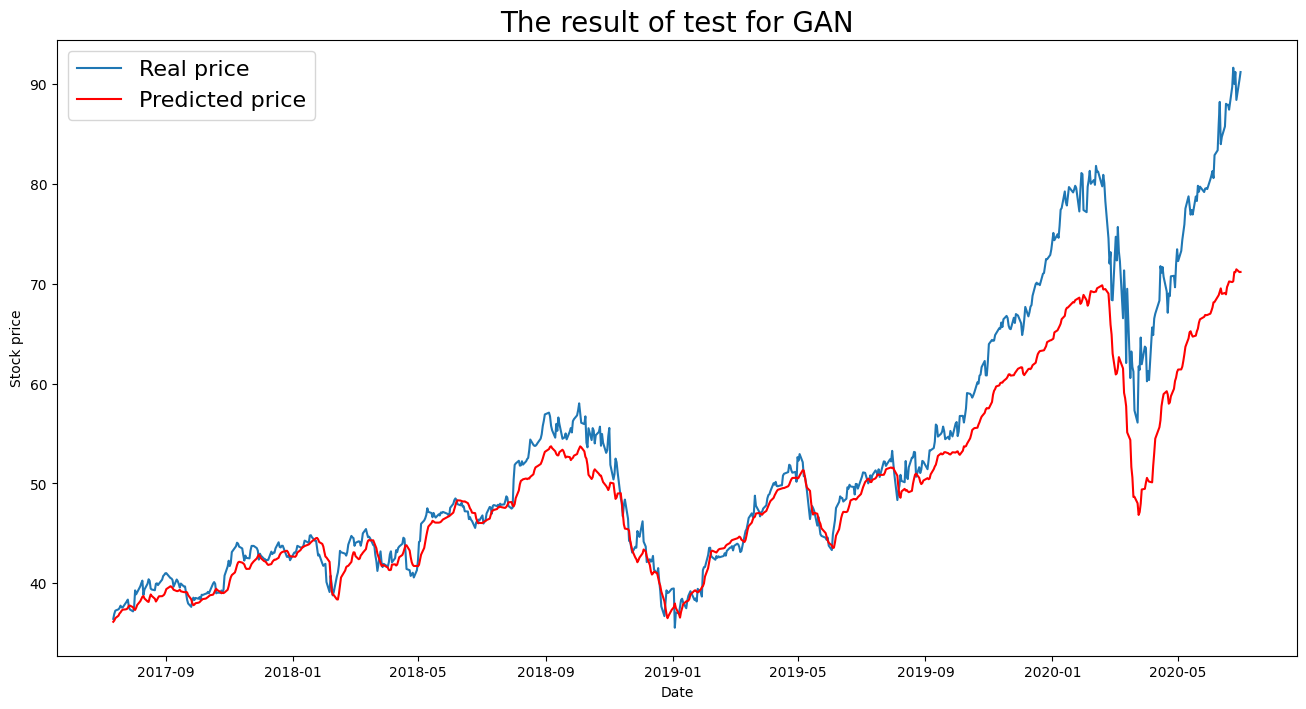

-- RMSE for GAN --  5.633001050984531


/tmp/ipykernel_15769/3651076424.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
/tmp/ipykernel_15769/3651076424.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


<Figure size 640x480 with 0 Axes>

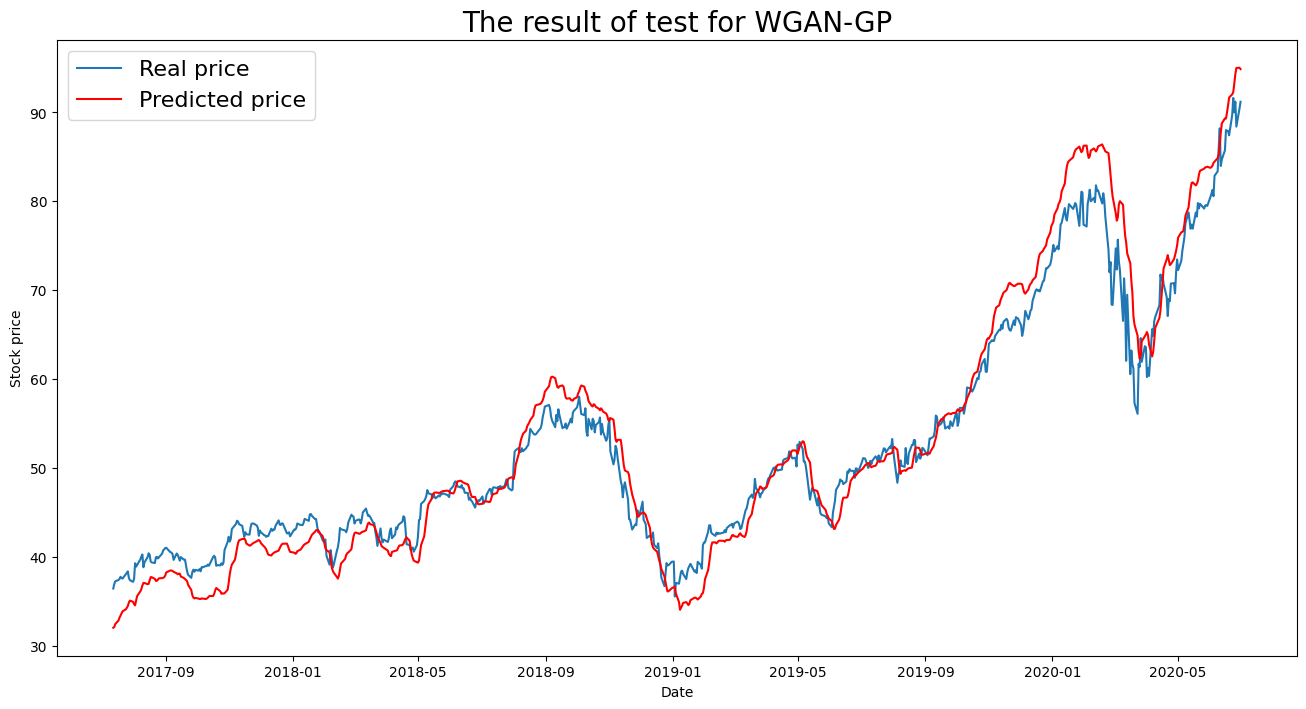

-- RMSE for WGAN-GP --  3.0695963864759075


<Figure size 640x480 with 0 Axes>

In [19]:
def get_test_plot(model, X_test, y_test, model_name):
    # Set output steps
    output_dim = y_test.shape[1]

    # Get predicted data
    y_predicted = model(X_test)
    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

    ## Predicted price
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"The result of test for {model_name}", fontsize=20)
    plt.show()
    plt.savefig(f'test_plot_{model_name}.png')
    
    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print(f'-- RMSE for {model_name} -- ', RMSE)

    return predict_result, RMSE

# Load and evaluate the first model
G_model_1 = tf.keras.models.load_model('gen_model_3_1_164.h5')
test_predicted_1, test_RMSE_1 = get_test_plot(G_model_1, X_test, y_test, 'GAN')

# Save predictions to CSV
test_predicted_1.to_csv("test_predicted_1.csv")

# Load and evaluate the second model
G_model_2 = tf.keras.models.load_model('gen_GRU_model_89.h5')
test_predicted_2, test_RMSE_2 = get_test_plot(G_model_2, X_test, y_test, 'WGAN-GP')

# Save predictions to CSV
test_predicted_2.to_csv("test_predicted_2.csv")

######### Test dataset #########
##### For last set #########
# Rescale back the real dataset

X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))
train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)

# Load model
G_model = tf.keras.models.load_model('gen_GRU_model_89.h5')

X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)

y_test_hat = G_model(X_test[-1].reshape(1, X_test[-1].shape[0], X_test[-1].shape[1]))
rescaled_real_ytest = y_scaler.inverse_transform(y_test[-32:])
rescaled_predicted_ytest = y_scaler.inverse_transform(y_test_hat)
output_dim = 3

## Real price
real_price = pd.DataFrame()
for i in range(rescaled_real_ytest.shape[0]):
    test_predict_index = test_predict_index[-34:]
    y_train = pd.DataFrame(rescaled_real_ytest[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

## Predicted price
predict_result = pd.DataFrame()
y_predict = pd.DataFrame(rescaled_predicted_ytest[0], columns=["predicted_price"], index=test_predict_index[-3:])
predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)



predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)
#
# Plot the predicted result
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color = 'r')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.ylim(0, 100)
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title("The result of the last set of testdata", fontsize=20)
plt.show()
plt.savefig('single_test_plot.png')

# Calculate RMSE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real[-3:]))
print('-- test dataset RMSE -- ', RMSE)